# Load and Pre-process Data

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2022-05-31 13:09:49--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  19.8MB/s    in 0.6s    

2022-05-31 13:09:49 (19.8 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [ ]:
!tar -xzf nips12raw_str602.tgz

In [ ]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips07', 'nips02', 'nips09', 'nips00', 'README_yann', 'nips12', 'nips08', 'idx', 'MATLAB_NOTES', 'nips06', 'RAW_DATA_NOTES', 'nips01', 'nips10', 'nips05', 'nips03', 'nips11', 'nips04', 'orig']


In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [ ]:
print(papers[1494][:1000])

The effect of eligibility traces on finding optimal memoryless 
policies in partially observable Markov decision processes 
John Loch 
Department of Computer Science 
University of Colorado 
Boulder, CO 80309-0430 
l ochcs.colorado.edu 
Abstract 
Agents acting in the real world are confronted with the problem of 
making good decisions with limited knowledge of the environment. 
Partially observable Markov decision processes (POMDPs) model 
decision problems in which an agent tries to maximize its reward in the 
face of limited sensor feedback. Recent work has shown empirically that 
a reinforcement learning (RL) algorithm called Sarsa(.) can efficiently 
find optimal memoryless policies, which map current observations to 
actions, for POMDP problems (Loch and Singh 1998). The Sarsa().) 
algorithm uses a form of short-term memory called an eligibility trace, 
which distributes temporally delayed rewards to observation-action 
pairs which lead up to the reward. This paper explores the

## Basic Text Wrangling

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
%%time
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 35.4 s, sys: 367 ms, total: 35.8 s
Wall time: 36.4 s


# Text Representation with Feature Engineering

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer

#cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2),
                    # token_pattern=None, tokenizer=lambda doc: doc,
                     #preprocessor=lambda doc: doc)
#cv_features = cv.fit_transform(norm_papers)
#cv_features.shape

In [ ]:
#vocabulary = np.array(cv.get_feature_names())
#print('Total Vocabulary Size:', len(vocabulary))

# Topic Models with Latent Semantic Indexing (LSI)

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD

TOTAL_TOPICS = 20

lsi_model = TruncatedSVD(n_components=TOTAL_TOPICS, n_iter=500, random_state=42)
document_topics = lsi_model.fit_transform(cv_features)

CPU times: user 1min 5s, sys: 44.2 s, total: 1min 49s
Wall time: 1min 12s


In [ ]:
topic_terms = lsi_model.components_
topic_terms.shape

(20, 14408)

In [ ]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([topic_terms[row, columns] 
                             for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t, w) for t, w in zip(terms, weights)], 
                          key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('state', 0.221), ('neuron', 0.169), ('image', 0.138), ('cell', 0.13), ('layer', 0.13), ('feature', 0.127), ('probability', 0.121), ('hidden', 0.114), ('distribution', 0.105), ('rate', 0.098), ('signal', 0.095), ('task', 0.093), ('class', 0.092), ('noise', 0.09), ('net', 0.089), ('recognition', 0.089), ('representation', 0.088), ('field', 0.082), ('rule', 0.082), ('step', 0.08)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('cell', 0.417), ('neuron', 0.39), ('response', 0.175), ('stimulus', 0.155), ('visual', 0.131), ('spike', 0.13), ('firing', 0.117), ('synaptic', 0.11), ('activity', 0.104), ('cortex', 0.097), ('field', 0.085), ('frequency', 0.085), ('direction', 0.082), ('circuit', 0.082), ('motion', 0.082)]
--------------------------------------------------
Direction 2: [('state', -0.289), ('probability', -0.109), ('hidden', -0.098), ('class', -0.091), ('policy',

In [ ]:
dt_df = pd.DataFrame(np.round(document_topics, 3), 
                     columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
dt_df.T

,0,1,2,3,4,5,6,7,8,9,...,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739
T1,48.409,53.546,41.058,30.911,32.520,32.834,57.132,34.128,52.755,18.564,...,40.425,41.720,33.927,24.986,30.168,38.348,46.058,46.374,25.437,23.326
T2,25.419,-33.208,-11.349,-0.753,30.041,5.514,-2.042,-0.007,2.728,14.341,...,-28.742,28.335,4.612,16.211,-13.641,-10.105,-11.195,26.277,-13.793,-8.441
T3,-9.621,66.959,25.269,-2.652,15.089,-5.521,-16.104,18.723,1.429,8.551,...,31.823,-9.267,-3.017,20.085,-8.832,14.707,-45.472,-14.205,-9.863,-4.321
T4,19.801,34.736,2.506,6.416,12.833,8.966,10.279,1.518,39.023,-7.982,...,15.627,25.008,5.897,-5.853,-15.665,3.047,23.541,16.542,-14.134,-9.948
T5,-13.584,-1.940,-0.431,8.698,-8.494,-10.962,12.151,16.546,-5.234,4.529,...,-6.168,-12.912,-1.566,9.197,-9.389,-5.414,-20.470,4.196,-12.728,-10.679
T6,-16.469,1.574,-5.521,2.623,25.439,-14.726,5.115,-11.580,-0.957,-6.067,...,4.616,2.365,0.549,-21.229,-0.456,1.684,-19.396,4.739,0.285,-0.590
T7,-6.126,8.205,-0.760,-14.382,-1.665,-9.546,-28.920,-5.158,-17.289,4.574,...,-2.428,-3.273,5.065,5.444,0.796,5.123,15.697,1.345,6.087,1.085
T8,15.729,-8.684,-5.870,3.203,4.501,3.658,-11.983,-13.321,-0.227,-3.956,...,-2.270,4.988,23.124,-5.078,-9.230,17.836,-16.684,-11.902,-2.722,-0.888
T9,11.130,-1.097,-2.528,10.565,19.309,17.199,-21.620,-5.996,-2.465,-1.691,...,-13.175,-4.896,12.026,2.686,11.324,-13.767,-20.269,-7.338,3.244,-1.193
T10,3.403,-1.168,6.132,-8.174,-0.569,19.623,-4.162,9.756,-12.342,-3.320,...,3.501,-1.794,-10.398,5.685,-12.461,8.147,8.319,-17.419,-7.186,-0.992


In [ ]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(dt_df.columns[np.argsort(-np.absolute(dt_df.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T1', 'T6', 'T3']
Paper Summary:
775 
A NEURAL-NETWORK SOLUTION TO THE CONCENTRATOR 
ASSIGNMENT PROBLEM 
Gene A. Tagliarini 
Edward W. Page 
Department of Computer Science, Clemson University, Clemson, SC 
29634-1906 
ABSTRACT 
Networks of simple analog processors having neuron-like properties have 
been employed to compute good solutions to a variety of optimization prob- 
lems. This paper presents a neural-net solution to a resource allocation prob- 
lem that arises in providing local access to the backbone of a wide-area com

Document #250:
Dominant Topics (top 3): ['T1', 'T7', 'T12']
Paper Summary:
482 Saha and Keeler 
Algorithms for Better Representation and 
Faster Learning in Radial 
Basis Function Networks 
Avijit Saha 1 
James D. Keeler 
Microelectronics and Computer Technology corporation 
3500 West Balcones Center Drive 
Austin, Tx 78759 
ABSTRACT 
In this paper we present upper bounds for the learning rates for 
hybrid models that emp

# Topic Models with Latent Dirichlet Allocation (LDA)

In [ ]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components =TOTAL_TOPICS, max_iter=500, max_doc_update_iter=50,
                                      learning_method='online', batch_size=1740, learning_offset=50., 
                                      random_state=42, n_jobs=16)
document_topics = lda_model.fit_transform(cv_features)

In [ ]:
topic_terms = lda_model.components_

In [ ]:
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
dt_df.T

In [ ]:
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_contrib_topics = dt_df.max(axis=0)
dominant_topics = max_contrib_topics.index
contrib_perc = max_contrib_topics.values
document_numbers = [dt_df[dt_df[t] == max_contrib_topics.loc[t]].index[0]
                       for t in dominant_topics]
documents = [papers[i] for i in document_numbers]

results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Contribution %': contrib_perc,
                          'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'], 
                          'Paper Name': documents})
results_df

# Topic Models with Non-Negative Matrix Factorization (NMF)

In [ ]:
#%%time
#from sklearn.decomposition import NMF

#nmf_model = NMF(n_components=TOTAL_TOPICS, solver='cd', max_iter=500,
                #random_state=42, alpha=.1, l1_ratio=.85)
#document_topics = nmf_model.fit_transform(cv_features)

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2022-05-31 13:14:45--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz.1’

nips12raw_str602.tg 100%[===================>]  12.26M  19.0MB/s    in 0.6s    

2022-05-31 13:14:46 (19.0 MB/s) - ‘nips12raw_str602.tgz.1’ saved [12851423/12851423]



In [ ]:
!tar -xzf nips12raw_str602.tgz

In [ ]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips07', 'nips02', 'nips09', 'nips00', 'README_yann', 'nips12', 'nips08', 'idx', 'MATLAB_NOTES', 'nips06', 'RAW_DATA_NOTES', 'nips01', 'nips10', 'nips05', 'nips03', 'nips11', 'nips04', 'orig']


In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [ ]:
print(papers[0][:1000])

554 
STABILITY RESULTS FOR NEURAL NETWORKS 
A. N. Michel  , J. A. Farrell  , and W. Porod 2 
Department of Electrical and Computer Engineering 
University of Notre Dame 
Notre Dame, IN 46556 
ABSTRACT 
In the present paper we survey mad utilize results from the qualitative theory of large 
scale interconnected dynamical systems in order to develop a qualitative theory for the 
Hop field model of neural networks. In our approach we view such networks as an inter- 
connection of many single neurons. Our results are phrased in terms of the qualitative 
properties of the individual neurons and in terms of the properties of the interconnecting 
structure of the neural networks. Aspects of neural networks which we address include 
asymptotic stability, exponential stability, and instability of an equilibrium; estimates 
of trajectory bounds; estimates of the domain of attraction of an asymptotically stable 
equilibrium; and stability of neural networks under structural perturbations. 
INTR

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
%%time
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 39.5 s, sys: 399 ms, total: 39.9 s
Wall time: 45.6 s


In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

In [ ]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter='_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['stability', 'result', 'neural_network', 'michel', 'farrell', 'porod', 'department_electrical', 'computer_engineering', 'university', 'notre', 'dame', 'notre', 'dame', 'abstract_present', 'paper', 'survey', 'mad', 'utilize', 'result', 'qualitative', 'theory', 'large_scale', 'interconnected', 'dynamical_system', 'order', 'develop', 'qualitative', 'theory', 'hop_field', 'model', 'neural_network', 'approach', 'view', 'network', 'inter', 'connection', 'many', 'single', 'neuron', 'result', 'phrased', 'term', 'qualitative', 'property', 'individual', 'neuron', 'term', 'property', 'interconnecting', 'structure']


In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '2the'), (1, '2xi'), (2, '__1'), (3, '_aii'), (4, '_bl'), (5, '_k_'), (6, '_o'), (7, '_to'), (8, 'aaalysis'), (9, 'able'), (10, 'abstract_present'), (11, 'acad_sci'), (12, 'academic_press'), (13, 'accomplish'), (14, 'achieve')]
Total Vocabulary Size: 78892


In [ ]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))


Total Vocabulary Size: 7756


In [ ]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(10, 1), (17, 1), (19, 1), (29, 1), (31, 1), (40, 1), (63, 1), (76, 1), (77, 1), (89, 8), (95, 1), (96, 1), (104, 6), (125, 2), (127, 1), (137, 2), (148, 2), (187, 2), (195, 1), (201, 1), (203, 5), (219, 1), (223, 2), (224, 5), (229, 4), (236, 1), (253, 1), (256, 3), (258, 12), (262, 3), (271, 3), (272, 4), (276, 1), (283, 3), (287, 2), (290, 2), (292, 1), (295, 4), (296, 8), (297, 10), (298, 4), (319, 1), (321, 43), (325, 1), (328, 1), (331, 1), (332, 1), (338, 4), (340, 1), (348, 1)]


In [ ]:
%%time
TOTAL_TOPICS = 9
lda_model = gensim.models.Nmf(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                    random_state=42,
                                    num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 6.55 s, sys: 2.31 s, total: 8.86 s
Wall time: 6.45 s


In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=22, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.062*"unit" + 0.013*"pattern" + 0.011*"layer" + 0.009*"rule" + 0.009*"activation" + 0.008*"hidden_unit" + 0.007*"representation" + 0.007*"net" + 0.006*"connection" + 0.006*"structure" + 0.005*"activity" + 0.005*"motion" + 0.005*"architecture" + 0.004*"local" + 0.004*"direction" + 0.004*"connectionist" + 0.004*"sequence" + 0.003*"role" + 0.003*"object" + 0.003*"response"

Topic #2:
0.009*"distribution" + 0.007*"noise" + 0.005*"linear" + 0.005*"approximation" + 0.005*"signal" + 0.005*"variable" + 0.004*"equation" + 0.004*"rate" + 0.004*"estimate" + 0.004*"probability" + 0.004*"gaussian" + 0.004*"sample" + 0.004*"matrix" + 0.004*"vector" + 0.003*"density" + 0.003*"theory" + 0.003*"bound" + 0.003*"let" + 0.003*"consider" + 0.003*"component"

Topic #3:
0.017*"control" + 0.012*"vector" + 0.009*"memory" + 0.007*"dynamic" + 0.007*"controller" + 0.006*"trajectory" + 0.006*"state" + 0.005*"equation" + 0.005*"matrix" + 0.004*"optimal" + 0.004*"rule" + 0.004*"adaptive" + 0.004*"solution

In [ ]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('training', 0.041), ('task', 0.019), ('trained', 0.011), ('target', 0.007), ('test', 0.007), ('training_set', 0.007), ('architecture', 0.006), ('expert', 0.006), ('prediction', 0.006), ('control', 0.005), ('experiment', 0.005), ('step', 0.005), ('learn', 0.004), ('table', 0.004), ('generalization', 0.004), ('average', 0.003), ('learned', 0.003), ('hidden_unit', 0.003), ('best', 0.003), ('train', 0.003)]

Topic #2:
[('neuron', 0.08), ('pattern', 0.01), ('synaptic', 0.01), ('connection', 0.009), ('activity', 0.008), ('spike', 0.008), ('neural', 0.006), ('firing', 0.006), ('synapsis', 0.006), ('layer', 0.006), ('dynamic', 0.005), ('stimulus', 0.005), ('synapse', 0.005), ('threshold', 0.005), ('et_al', 0.005), ('simulation', 0.005), ('response', 0.004), ('activation', 0.004), ('neuronal', 0.004), ('biological', 0.004)]

Topic #3:
[('solution', 0.014), ('equation', 0.014), ('step', 0.008), ('optimal', 0.008), ('convergence', 0.007), ('rate', 0.007), ('est

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()



print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)

Avg. Coherence Score (Cv): 0.4578780390997284
Avg. Coherence Score (UMass): -1.2289735180106842


In [ ]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=30, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)
    
    return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=1)

100%|██████████| 29/29 [28:36<00:00, 59.19s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
0,2,0.4579
15,17,0.4579
27,29,0.4579
26,28,0.4579
25,27,0.4579
24,26,0.4579
23,25,0.4579
22,24,0.4579
21,23,0.4579
20,22,0.4579


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax1 = range(2, 31, 1)
y_ax1 = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax1, y_ax1, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.2289735180106844


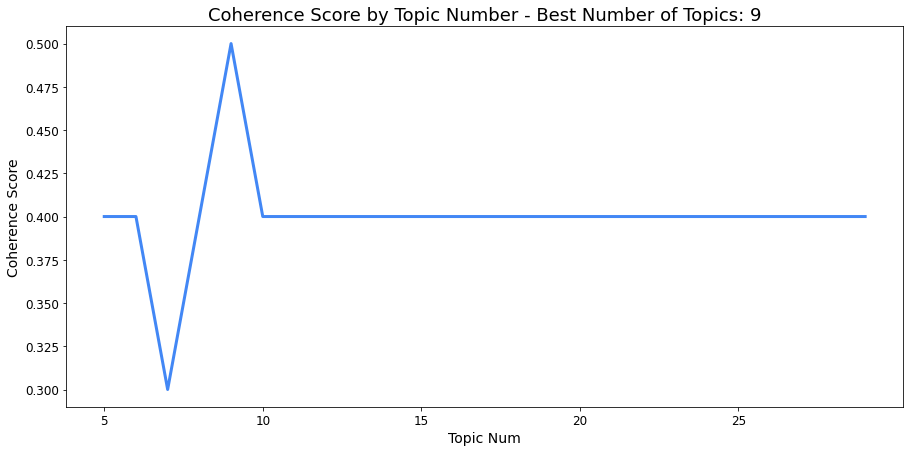

In [ ]:
# Use Gensim's NMF to get the best num of topics via coherence score
#texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id

# Filter out extremes to limit the number of features

# Create the bag-of-words format (list of (token_id, token_count))

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5,30, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=bow_corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=norm_corpus_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 1))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax1 = range(2,31,1)
y_ax1 = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax1, y_ax1, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [ ]:
scores

[(5, 0.4),
 (6, 0.4),
 (7, 0.3),
 (8, 0.4),
 (9, 0.5),
 (10, 0.4),
 (11, 0.4),
 (12, 0.4),
 (13, 0.4),
 (14, 0.4),
 (15, 0.4),
 (16, 0.4),
 (17, 0.4),
 (18, 0.4),
 (19, 0.4),
 (20, 0.4),
 (21, 0.4),
 (22, 0.4),
 (23, 0.4),
 (24, 0.4),
 (25, 0.4),
 (26, 0.4),
 (27, 0.4),
 (28, 0.4),
 (29, 0.4)]

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] ==9].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

22

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['unit', 'pattern', 'layer', 'rule', 'activation', 'hidden_unit', 'representation', 'net', 'connection', 'structure', 'activity', 'motion', 'architecture', 'local', 'direction', 'connectionist', 'sequence', 'role', 'object', 'response']

Topic #2:
['distribution', 'noise', 'linear', 'approximation', 'signal', 'variable', 'equation', 'rate', 'estimate', 'probability', 'gaussian', 'sample', 'matrix', 'vector', 'density', 'theory', 'bound', 'let', 'consider', 'component']

Topic #3:
['control', 'vector', 'memory', 'dynamic', 'controller', 'trajectory', 'state', 'equation', 'matrix', 'optimal', 'rule', 'adaptive', 'solution', 'change', 'action', 'step', 'linear', 'movement', 'line', 'position']

Topic #4:
['state', 'action', 'policy', 'step', 'probability', 'sequence', 'transition', 'reinforcement_learning', 'task', 'reward', 'agent', 'machine', 'optimal', 'environment', 'mdp', 'current', 'stochastic', 'goal', 'recurrent', 'hidden']

Topic #5:
['word', 'recognition', 'training', 

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['training', 'task', 'trained', 'target', 'test', 'training_set', 'architecture', 'expert', 'prediction', 'control', 'experiment', 'step', 'learn', 'table', 'generalization', 'average', 'learned', 'hidden_unit', 'best', 'train']

Topic #2:
['structure', 'variable', 'matrix', 'representation', 'graph', 'local', 'role', 'binding', 'tree', 'sequence', 'continuous', 'element', 'edge', 'parallel', 'processor', 'represented', 'constraint', 'node', 'vector', 'xi']

Topic #3:
['distribution', 'class', 'probability', 'approximation', 'sample', 'prior', 'mixture', 'gaussian', 'density', 'bound', 'variable', 'tree', 'log', 'estimate', 'bayesian', 'component', 'classification', 'posterior', 'likelihood', 'xi']

Topic #4:
['memory', 'image', 'linear', 'vector', 'nonlinear', 'component', 'capacity', 'noise', 'prediction', 'hidden_unit', 'pca', 'training', 'representation', 'net', 'transformation', 'matrix', 'manifold', 'layer', 'address', 'associative_memory']

Topic #5:
['object', 'view',

In [ ]:
topics1 = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['unit', 'pattern', 'layer', 'rule', 'activation', 'hidden_unit', 'representation', 'net', 'connection', 'structure', 'activity', 'motion', 'architecture', 'local', 'direction', 'connectionist', 'sequence', 'role', 'object', 'response']

Topic #2:
['distribution', 'noise', 'linear', 'approximation', 'signal', 'variable', 'equation', 'rate', 'estimate', 'probability', 'gaussian', 'sample', 'matrix', 'vector', 'density', 'theory', 'bound', 'let', 'consider', 'component']

Topic #3:
['control', 'vector', 'memory', 'dynamic', 'controller', 'trajectory', 'state', 'equation', 'matrix', 'optimal', 'rule', 'adaptive', 'solution', 'change', 'action', 'step', 'linear', 'movement', 'line', 'position']

Topic #4:
['state', 'action', 'policy', 'step', 'probability', 'sequence', 'transition', 'reinforcement_learning', 'task', 'reward', 'agent', 'machine', 'optimal', 'environment', 'mdp', 'current', 'stochastic', 'goal', 'recurrent', 'hidden']

Topic #5:
['word', 'recognition', 'training', 

In [ ]:
topics1 = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['unit', 'pattern', 'layer', 'rule', 'activation', 'hidden_unit', 'representation', 'net', 'connection', 'structure', 'activity', 'motion', 'architecture', 'local', 'direction', 'connectionist', 'sequence', 'role', 'object', 'response']

Topic #2:
['distribution', 'noise', 'linear', 'approximation', 'signal', 'variable', 'equation', 'rate', 'estimate', 'probability', 'gaussian', 'sample', 'matrix', 'vector', 'density', 'theory', 'bound', 'let', 'consider', 'component']

Topic #3:
['control', 'vector', 'memory', 'dynamic', 'controller', 'trajectory', 'state', 'equation', 'matrix', 'optimal', 'rule', 'adaptive', 'solution', 'change', 'action', 'step', 'linear', 'movement', 'line', 'position']

Topic #4:
['state', 'action', 'policy', 'step', 'probability', 'sequence', 'transition', 'reinforcement_learning', 'task', 'reward', 'agent', 'machine', 'optimal', 'environment', 'mdp', 'current', 'stochastic', 'goal', 'recurrent', 'hidden']

Topic #5:
['word', 'recognition', 'training', 

In [ ]:
topics_df1 = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics1], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df1

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term1,unit,distribution,control,state,word,image,training,cell,neuron
Term2,pattern,noise,vector,action,recognition,object,feature,response,pattern
Term3,layer,linear,memory,policy,training,feature,class,stimulus,circuit
Term4,rule,approximation,dynamic,step,node,pixel,classifier,visual,current
Term5,activation,signal,controller,probability,character,face,task,activity,synaptic
Term6,hidden_unit,variable,trajectory,sequence,sequence,representation,classification,feature,chip
Term7,representation,equation,state,transition,level,visual,training_set,cortical,layer
Term8,net,rate,equation,reinforcement_learning,hmm,view,trained,motion,connection
Term9,connection,estimate,matrix,task,speech,vector,pattern,spatial,synapse
Term10,structure,probability,optimal,reward,phoneme,recognition,test,layer,spike


In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22
Term1,training,structure,distribution,memory,object,signal,unit,solution,vector,unit,...,size,classifier,circuit,image,pattern,neuron,state,word,control,cell
Term2,task,variable,class,image,view,motion,hidden_unit,equation,code,pattern,...,class,training,chip,feature,feature,pattern,action,recognition,dynamic,response
Term3,trained,matrix,probability,linear,unit,image,net,step,feature,layer,...,threshold,class,current,face,node,synaptic,policy,character,controller,stimulus
Term4,target,representation,approximation,vector,visual,spike,task,optimal,sequence,activity,...,theorem,classification,voltage,pixel,tree,connection,reinforcement_learning,training,map,cortical
Term5,test,graph,sample,nonlinear,layer,filter,noise,convergence,matrix,state,...,concept,pattern,analog,representation,training,activity,step,net,trajectory,activity
Term6,training_set,local,prior,component,net,visual,activation,rate,bit,sequence,...,hypothesis,error_rate,signal,recognition,representation,spike,task,hmm,state,firing
Term7,architecture,role,mixture,capacity,representation,stimulus,feature,estimate,word,representation,...,machine,rbf,noise,task,probability,neural,agent,level,movement,cortex
Term8,expert,binding,gaussian,noise,recognition,velocity,level,noise,map,recurrent,...,bound,training_set,transistor,target,part,firing,transition,speech,prediction,contrast
Term9,prediction,tree,density,prediction,part,rate,approximation,matrix,distance,architecture,...,let,center,design,object,classification,synapsis,reward,context,feedback,spatial
Term10,control,sequence,bound,hidden_unit,position,noise,center,approximation,cost,module,...,complexity,test,channel,human,stimulus,layer,probability,phoneme,neural,effect


In [ ]:
topics_df_9 = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics1], 
                         columns = ['Term'+str(i) for i in range(1,21)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df_9

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Term1,unit,distribution,control,state,word,image,training,cell,neuron
Term2,pattern,noise,vector,action,recognition,object,feature,response,pattern
Term3,layer,linear,memory,policy,training,feature,class,stimulus,circuit
Term4,rule,approximation,dynamic,step,node,pixel,classifier,visual,current
Term5,activation,signal,controller,probability,character,face,task,activity,synaptic
Term6,hidden_unit,variable,trajectory,sequence,sequence,representation,classification,feature,chip
Term7,representation,equation,state,transition,level,visual,training_set,cortical,layer
Term8,net,rate,equation,reinforcement_learning,hmm,view,trained,motion,connection
Term9,connection,estimate,matrix,task,speech,vector,pattern,spatial,synapse
Term10,structure,probability,optimal,reward,phoneme,recognition,test,layer,spike


In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"training, task, trained, target, test, training_set, architecture, expert, prediction, control, experiment, step, learn, table, generalization, average, learned, hidden_unit, best, train"
Topic2,"structure, variable, matrix, representation, graph, local, role, binding, tree, sequence, continuous, element, edge, parallel, processor, represented, constraint, node, vector, xi"
Topic3,"distribution, class, probability, approximation, sample, prior, mixture, gaussian, density, bound, variable, tree, log, estimate, bayesian, component, classification, posterior, likelihood, xi"
Topic4,"memory, image, linear, vector, nonlinear, component, capacity, noise, prediction, hidden_unit, pca, training, representation, net, transformation, matrix, manifold, layer, address, associative_memory"
Topic5,"object, view, unit, visual, layer, net, representation, recognition, part, position, scheme, spatial, frame, aspect, location, feature, hand, shape, transformation, action"
Topic6,"signal, motion, image, spike, filter, visual, stimulus, velocity, rate, noise, response, direction, estimate, local, constant, shape, frequency, spike_train, temporal, change"
Topic7,"unit, hidden_unit, net, task, noise, activation, feature, level, approximation, center, ob, connection, rbf, effect, solution, energy, region, learn, average, back_propagation"
Topic8,"solution, equation, step, optimal, convergence, rate, estimate, noise, matrix, approximation, gradient, iteration, constraint, variance, eq, distribution, linear, state, estimation, optimization"
Topic9,"vector, code, feature, sequence, matrix, bit, word, map, distance, cost, loss, length, representation, neuron, classification, component, cn, element, mapping, line"
Topic10,"unit, pattern, layer, activity, state, sequence, representation, recurrent, architecture, module, connection, motion, symbol, role, direction, step, hidden_unit, context, structure, stage"


In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df_9 = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics1],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1,lda_model.num_topics+1)]
                         )
topics_df_9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"unit, pattern, layer, rule, activation, hidden_unit, representation, net, connection, structure, activity, motion, architecture, local, direction, connectionist, sequence, role, object, response"
Topic2,"distribution, noise, linear, approximation, signal, variable, equation, rate, estimate, probability, gaussian, sample, matrix, vector, density, theory, bound, let, consider, component"
Topic3,"control, vector, memory, dynamic, controller, trajectory, state, equation, matrix, optimal, rule, adaptive, solution, change, action, step, linear, movement, line, position"
Topic4,"state, action, policy, step, probability, sequence, transition, reinforcement_learning, task, reward, agent, machine, optimal, environment, mdp, current, stochastic, goal, recurrent, hidden"
Topic5,"word, recognition, training, node, character, sequence, level, hmm, speech, phoneme, context, frame, letter, probability, rule, segmentation, state, trained, sentence, architecture"
Topic6,"image, object, feature, pixel, face, representation, visual, view, vector, recognition, local, region, transformation, shape, texture, filter, location, scale, position, linear"
Topic7,"training, feature, class, classifier, task, classification, training_set, trained, pattern, test, net, vector, hidden_unit, experiment, prediction, table, sample, size, probability, machine"
Topic8,"cell, response, stimulus, visual, activity, feature, cortical, motion, spatial, layer, firing, orientation, cortex, receptive_field, direction, rat, map, signal, contrast, et_al"
Topic9,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing"


In [ ]:
tm_results_9 = lda_model[bow_corpus]

In [ ]:
tm_results = best_lda_model[bow_corpus]

In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(5, 0.47299238182998143),
 (18, 0.5509209611294924),
 (12, 0.2228334169744755),
 (0, 0.5211968005573199),
 (21, 0.4357151533389211)]

In [ ]:
corpus_topics_9 = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results_9]
corpus_topics_9[:5]

[(1, 0.521576643634223),
 (7, 0.5399603748489279),
 (3, 0.44372697623515234),
 (2, 0.404494395817314),
 (8, 0.7880509721956359)]

In [ ]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers
corpus_topic_df.head()

In [ ]:
corpus_topic_df_9 = pd.DataFrame()
corpus_topic_df_9['Document'] = range(0, len(papers))
corpus_topic_df_9['Dominant Topic'] = [item[0]+1 for item in corpus_topics_9]
corpus_topic_df_9['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics_9]
corpus_topic_df_9['Topic Desc'] = [topics_df_9.iloc[t[0]]['Terms per Topic'] for t in corpus_topics_9]
corpus_topic_df_9['Paper'] = papers
corpus_topic_df_9.head()

Document  Dominant Topic  Contribution %  \
0  0         2               52.16            
1  1         8               54.00            
2  2         4               44.37            
3  3         3               40.45            
4  4         9               78.81            

                                                                                                                                                                                      Topic Desc  \
0  distribution, noise, linear, approximation, signal, variable, equation, rate, estimate, probability, gaussian, sample, matrix, vector, density, theory, bound, let, consider, component         
1  cell, response, stimulus, visual, activity, feature, cortical, motion, spatial, layer, firing, orientation, cortex, receptive_field, direction, rat, map, signal, contrast, et_al               
2  state, action, policy, step, probability, sequence, transition, reinforcement_learning, task, reward, agent, machine, optimal, environment, mdp, current, stochastic, goal, recurrent, hidden   
3  control, vector, memory, dynamic, controller, trajectory, state, equation, matrix, optimal, rule, adaptive, solution, change, action, step, linear, movement, line, position                    
4  neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing                

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Dominant Topic']
                 .isin([20])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
42,42,20,37.05,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","144 \nSPEECH RECOGNITION EXPERIMENTS \nWITH PERCEPTRONS \nD. J. Burr \nBell Communications Research \nMorristown, NJ 07960 \nABSTRACT \nArtificial neural networks (ANNs) are capable of accurate re..."
152,152,20,22.38,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","224 \nUSE OF MULTI-LAYERED NETWORKS FOR \nCODING SPEECH WITH PHONETIC FEATURES \nYoshua Bengio, Regis Cardin \nand Renato De Mori \nComputer Science Dept. \nMcGill University \nMontreal, Canada H3..."
174,174,20,21.42,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture",796 \nSPEECH RECOGNITION: STATISTICAL AND \nNEURAL INFORMATION PROCESSING \nAPPROACHES \nJohn S. Bridle \nSpeech Research Unit and \nNational Electronics Research Initiative in Pattern Recognition...
223,223,20,32.87,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture",Connectionist Architectures for Multi-Speaker Phoneme Recognition 203 \nConnectionist Architectures for Multi-Speaker \nPhoneme Recognition \nJohn B. Hampshire H and Alex Waibel \nSchool of Comput...
248,248,20,33.41,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","364 Jain and Waibel \nIncremental Parsing by Modular Recurrent \nConnectionist Networks \nAjay N. Jain Alex H. Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 152..."
...,...,...,...,...,...
1391,1391,20,79.20,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","Serial Order in Reading Aloud: \nConnectionist Models and Neighborhood \nStructure \nJeanne C. Milostan_ \nComputer Science & Engineering 0114 \nUniversity of California San Diego \nLa Jolla, CA 9..."
1400,1400,20,96.29,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","Comparison of Human and Machine Word \nRecognition \nM. Schenkel \nDept of Electrical Eng. \nUniversity of Sydney \nSydney, NSW 2006, Australia \nschenkel@sedal.usyd.edu.au \nC. Latimer \nDept of ..."
1402,1402,20,48.91,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","! I \nAdaptation in Speech Motor Control \nJohn F. Houde* \nUCSF Keck Center \nBox 0732 \nSan Francisco, CA 94143 \nhoudephy. ucsf. edu \nMichael I. Jordan \nMIT Dept. of Brain and Cognitive Sci...."
1446,1446,20,24.51,"word, recognition, character, training, net, hmm, level, speech, context, phoneme, letter, frame, segmentation, probability, tdnn, trained, rate, layer, sequence, architecture","Controlling the Complexity of HMM Systems by \nRegularization \nChristoph Neukirchen, Gerhard Rigoil \nDepartment of Computer Science \nGerhard-Mercator-University Duisburg \n47057 Duisburg, Germa..."


In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df_9[corpus_topic_df_9['Dominant Topic']
                 .isin([9])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
4,4,9,78.81,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","457 \nDISTRIBUTED NEURAL INFORMATION PROCESSING \nIN THE VESTIBULO-OCULAR SYSTEM \nClifford Lau \nOffice of Naval Research Detachment \nPasadena, CA 91106 \nVicente Honrubia* \nUCLA Division of He..."
9,9,9,55.25,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing",804 \nINTRODUCTION TO A SYSTEM FOR IMPLEMENTING NEURAL NET \nCONNECTIONS ON SIMD ARCHITECTURES \nSherryl Tomboulian \nInstitute for Computer Applications in Science and Engineering \nNASA Langley ...
14,14,9,38.66,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","397 \nAN OPTIMIZATION NETWORK FOR MATRIX INVERSION \nJu-Seog Jang, Soo-Young Lee, and Sang-Yung Shin \nKorea Advanced Institute of Science and Technology, \nP.O. Box 150, Cheongryang, Seoul, Korea..."
21,21,9,63.30,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing",31 \nAN ARTIFICIAL NEURAL NETWORK FOR SPATIO- \nTEMPORAL BIPOLAR PATTERNS: APPLICATION TO \nPHONEME CLASSIFICATION \nToshiteru Homma \nLes E. Atlas \nRobert J. Marks H \nInteractive Systems Design...
22,22,9,33.36,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","402 \nHOW THE CATFISH TRACKS ITS PREY: AN INTERACTIVE ""PIPELINED"" \nPROCESSING SYSTEM MAY DIRECT FORAGING VIA RETICULOSPINAL NEURONS. \nJagmeet S. Kanwal \nDept. of Cellular & Structural Biology, ..."
...,...,...,...,...,...
1666,1666,9,77.71,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","A Winner-Take-All Circuit with \nControllable Soft Max Property \nShih-Chii Liu \nInstitute for Neuroinformatics, ETH/UNIZ \nWinterthurstrasse 190, CH-8057 Zurich \nSwitzerland \nshih@ini.phys.eth..."
1673,1673,9,32.34,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","Kirchoff Law Markov Fields for Analog \nCircuit Design \nRichard M. Golden * \nRMG Consulting Inc. \n2000 Fresno Road, Plano, Texas 75074 \nRMG CONS UL T@A OL. COM, \nwww. neural-network. corn \nA..."
1709,1709,9,42.55,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","Wiring optimization in the brain \nDmitri B. Chklovskii \nSloan Center for \nTheoretical Neurobiology \nThe Salk Institute \nLa Jolla, CA 92037 \nmitya@salk. edu \nCharles F. Stevens \nHoward Hugh..."
1725,1725,9,80.17,"neuron, pattern, circuit, current, synaptic, chip, layer, connection, synapse, spike, neural, response, voltage, synapsis, threshold, stimulus, signal, activity, analog, firing","Bifurcation Analysis of a Silicon Neuron \nGirish N. Patel l, Gennady S. Cymbalyuk 2'3, \nRonald L. Calabrese 2, and Stephen P. DeWeerth 1 \n1School of Electrical and Computer Engineering \nGeorgi..."


In [ ]:
# NMF
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df_9[corpus_topic_df_9['Document']
                 .isin([1494])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
1494,1494,4,79.89,"state, action, policy, step, probability, sequence, transition, reinforcement_learning, task, reward, agent, machine, optimal, environment, mdp, current, stochastic, goal, recurrent, hidden",The effect of eligibility traces on finding optimal memoryless \npolicies in partially observable Markov decision processes \nJohn Loch \nDepartment of Computer Science \nUniversity of Colorado \n...


In [ ]:
# NMF
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df_9[corpus_topic_df_9['Document']
                 .isin([1494])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
1494,1494,4,79.89,"state, action, policy, step, probability, sequence, transition, reinforcement_learning, task, reward, agent, machine, optimal, environment, mdp, current, stochastic, goal, recurrent, hidden",The effect of eligibility traces on finding optimal memoryless \npolicies in partially observable Markov decision processes \nJohn Loch \nDepartment of Computer Science \nUniversity of Colorado \n...


In [ ]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': { np.size } })
topic_stats_df

,Dominant Topic
,size
Dominant Topic,
1,133
2,65
3,165
4,39
5,24
6,71
7,54
8,243


In [ ]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df_9 = corpus_topic_df_9.groupby('Dominant Topic').agg({
                                                'Dominant Topic': { np.size } })
topic_stats_df_9

,Dominant Topic
,size
Dominant Topic,
1,139
2,416
3,171
4,165
5,75
6,153
7,259
8,146


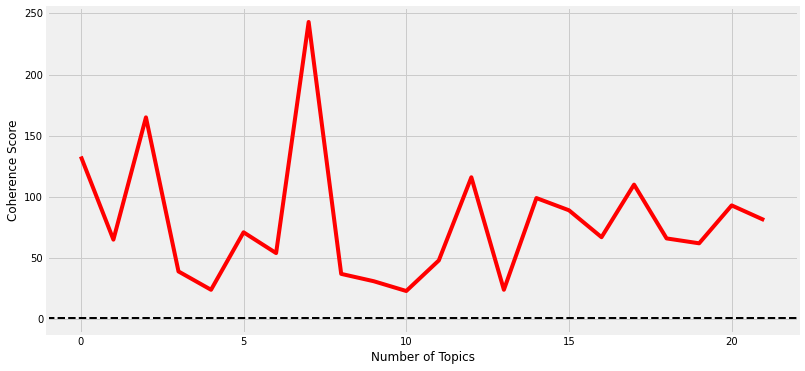

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(22)
y_ax = topic_stats_df
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')



Text(0, 0.5, 'total no.of documents')

<Figure size 1080x432 with 0 Axes>

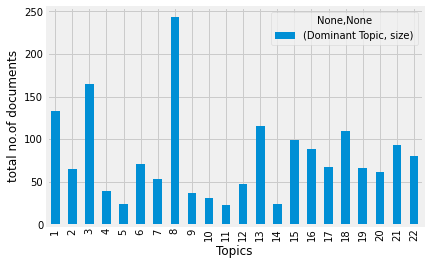

In [ ]:


data_df= topic_stats_df
plt.figure(figsize = (15, 6))
data_df.plot(kind = 'bar')
plt.xlabel('Topics')
plt.ylabel('total no.of documents')

Text(0, 0.5, 'total no.of documents')

<Figure size 1080x432 with 0 Axes>

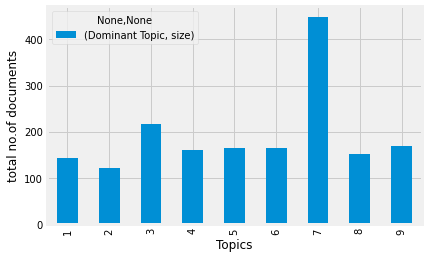

In [ ]:


data_df= topic_stats_df_9
plt.figure(figsize = (15, 6))
data_df.plot(kind = 'bar')
plt.xlabel('Topics')
plt.ylabel('total no.of documents')

In [ ]:
pd.set_option('display.max_colwidth', 200)
(topic_stats_df_9[topic_stats_df_9['Dominant Topic']
                 .isin([9])])

ValueError: ignored

In [ ]:
!pip install pynmfvis

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
vis

In [ ]:
from pathlib import Path
import re, joblib
from itertools import combinations
import numpy as np
from sklearn import decomposition
import gensim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
kmin, kmax = 4, 25

In [ ]:
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...


NameError: ignored

In [ ]:
best_num_topics
coherence_scores

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd
#PLOTTING TOOLS 
# import matplotlib.pyplot as PLOTTING   
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
kmin, kmax = 2, 30

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens

docgen = TokenGenerator(docs_raw, stop_words)
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

Applying NMF for k=2 ...


NameError: ignored

In [ ]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [ ]:
top_terms = 20
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
dt_df.head(10)

In [ ]:
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                       for t in dominant_topics]
documents = [papers[i] for i in document_numbers]

results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                          'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'], 
                          'Paper Name': documents})
results_df

# Predicting Topics for New Research Papers

In [ ]:
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [ ]:
print(new_papers[3][:2500])

PAC Reinforcement Learning with Rich Observations
Akshay Krishnamurthy
University of Massachusetts, Amherst
Amherst, MA, 01003
akshay@cs.umass.edu
Alekh Agarwal
Microsoft Research
New York, NY 10011
alekha@microsoft.com
John Langford
Microsoft Research
New York, NY 10011
jcl@microsoft.com
Abstract
We propose and study a new model for reinforcement learning with rich observations, generalizing contextual bandits to sequential decision making. These
models require an agent to take actions based on observations (features) with the
goal of achieving long-term performance competitive with a large set of policies.
To avoid barriers to sample-efficient learning associated with large observation
spaces and general POMDPs, we focus on problems that can be summarized by a
small number of hidden states and have long-term rewards that are predictable by a
reactive function class. In this setting, we design and analyze a new reinforcement
learning algorithm, Least Squares Value Elimination by Explo

In [ ]:
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

In [ ]:
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics
    

In [ ]:
topic_preds = get_topic_predictions(topic_model=lda_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(1, 0.632), (5, 0.183)],
 [(5, 0.49), (8, 0.354)],
 [(5, 0.604), (4, 0.365)],
 [(3, 0.773), (1, 0.174)]]

In [ ]:
results1_df = pd.DataFrame()
results1_df['Papers'] = range(1, len(new_papers)+1)
results1_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results1_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results1_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results1_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results1_df['Paper Desc'] = [new_papers[i-1][:200] for i in results1_df.index.values]
results1_df

,Dominant Topics,Contribution %,Paper Desc
Papers,,,
1,2,63.2,"Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S..."
1,6,18.3,"Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer S..."
2,6,49.0,"Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\..."
2,9,35.4,"Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\..."
3,6,60.4,"Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute..."
3,5,36.5,"Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute..."
4,4,77.3,"PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,..."
4,2,17.4,"PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York,..."


In [ ]:
norm_new_papers = normalize_corpus(new_papers)
cv_new_features = cv.transform(norm_new_papers)
cv_new_features.shape

In [ ]:
topic_predictions = nmf_model.transform(cv_new_features)
best_topics = [[(topic, round(sc, 3)) 
                    for topic, sc in sorted(enumerate(topic_predictions[i]), 
                                            key=lambda row: -row[1])[:2]] 
                        for i in range(len(topic_predictions))]
best_topics

In [ ]:
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, sc in item] for item in best_topics]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Topic Score'] = [topic_sc for topic_list in 
                                        [[round(sc*100, 2) 
                                              for topic_num, sc in item] 
                                                 for item in best_topics] 
                                    for topic_sc in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

results_df

# Persisting Model and Transformers

### This is just for visualizing the topics in the other notebook (since PyLDAViz expands the notebook size)

In [ ]:
import dill

with open('nmf_model.pkl', 'wb') as f:
    dill.dump(nmf_model, f)
with open('cv_features.pkl', 'wb') as f:
    dill.dump(cv_features, f)
with open('cv.pkl', 'wb') as f:
    dill.dump(cv, f)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = nmf_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
def word_cloud(topic, model):
    plt.figure(figsize = (8,6))
    topic_words = [model.print_topic(topic, 75)]
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                      width=2500, height=1800).generate(" ".join(topic_words))

    print('\nWordcloud for topic:', topic, '\n')
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

In [ ]:
for topic in range(20): 
    #plt.figure(figsize=(10,15)) 
    word_cloud(topic, nmf_model)